# Classificazione binaria "selfMade" con ANN (MLPClassifier) utilizzando i parametri di GridSearch


In [12]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import os
import sys
sys.path.append('../Scripts')
from utility import evaluate_and_save_model


X_train = pd.read_csv("../data/splitted/X_train.csv")
X_test = pd.read_csv("../data/splitted/X_test.csv")
y_train = pd.read_csv("../data/splitted/y_train.csv").values.ravel()
y_test = pd.read_csv("../data/splitted/y_test.csv").values.ravel()

In [13]:
X_train = X_train.drop(columns=['source'], errors='ignore')
X_train = X_train.loc[:, X_train.nunique() > 1]
X_test = X_test[X_train.columns]


X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())

In [14]:
# Standardizzazione
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Viene creato il modello con i parametri ottenuti tramite la ricerca gridSearch nel notebook 09a_ANN_selfMade.ipynb

In [15]:
# Modello MLP
model = MLPClassifier(
    activation='relu',
    alpha=0.01,
    hidden_layer_sizes=(100, 50),
    learning_rate='constant',
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=10,
    max_iter=300,
    random_state=42
)

model.fit(X_train_scaled, y_train)

MLPClassifier(alpha=0.01, early_stopping=True, hidden_layer_sizes=(100, 50),
              max_iter=300, random_state=42, validation_fraction=0.2)

In [16]:
# Predizioni
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

evaluate_and_save_model(
    model,
    "ann grid search",
    y_train,
    y_pred_train,
    y_test,
    y_pred_test,
    "../results/classification_selfMade/ann",
    "../models/ann_gridsearch_selfmade.joblib",
    {"activation":"relu","hidden_layer_sizes":(100,50),"alpha":0.01}
)

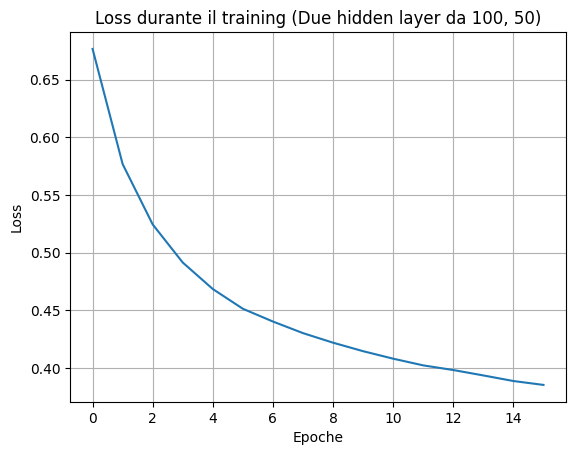

In [17]:
import matplotlib.pyplot as plt

plt.plot(model.loss_curve_)
plt.title("Loss durante il training (Due hidden layer da 100, 50)")
plt.xlabel("Epoche")
plt.ylabel("Loss")
plt.grid(True)
plt.savefig("../results/classification_selfMade/ann/loss_curve.png")
plt.show()
plt.close()

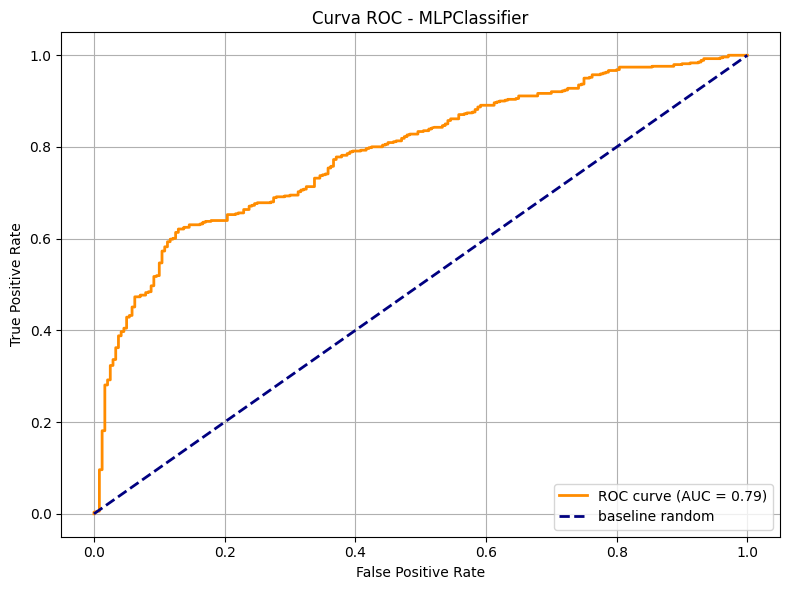

In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Calcolo delle probabilità predette
y_proba = model.predict_proba(X_test_scaled)[:, 1]

# Calcolo della curva ROC
fpr, tpr, soglie = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot della curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label = 'baseline random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - MLPClassifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()

plt.savefig("../results/classification_selfMade/ann/roc_curve.png")
plt.show()
